In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from Graph import *
from Azimuth import *
from math import sqrt
from copy import deepcopy, copy

import numpy as np

In [2]:
def vis(graph, xlim = None, ylim = None):
    fig, ax = plt.subplots(figsize = (7,7))
    ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

    for edge in graph.edges:
        lat1 = min(edge.vertices).latitude
        long1 = min(edge.vertices).longitude

        lat2 = max(edge.vertices).latitude
        long2 = max(edge.vertices).longitude

        plt.plot([lat1, lat2], [long1, long2], marker = 'o')

    star_vertices = [vertex for vertex in graph.vertices if len(vertex.edges) == 1]
    for vertex in star_vertices:
        ax.plot(vertex.latitude, vertex.longitude, markersize=50)

    ax = plt.gca()
    
    if xlim != None:
        ax.set_xlim(xlim)
        
    if ylim != None:
         ax.set_ylim(ylim)
    
    ax.ticklabel_format(useOffset=False, style='plain')

## Test the Graph class

In [3]:
graph = Graph(warnings = True)
graph.name = "1"

last_vertex = Vertex(-1, -1, 0, warnings = True)
graph.add_vertices(last_vertex)

for i in range(0,10):
    new_vertex = Vertex(i, i, 0, warnings = True)
    edge = Edge(vertices = [last_vertex, new_vertex], warnings = True)
    graph.add_vertices(new_vertex)
    last_vertex = new_vertex
    
graph_2 = Graph(warnings = True)
graph_2.name = "2"

last_vertex = Vertex(10, 10, 0, warnings = True)
graph_2.add_vertices(last_vertex)

for i in range(11,20):
    new_vertex = Vertex(i, i, 0, warnings = True)
    edge = Edge(vertices = [last_vertex, new_vertex], warnings = True)
    graph_2.add_vertices(new_vertex)
    last_vertex = new_vertex

In [4]:
graph.combine_graph(graph_2)

In [5]:
print(edge.vertices)
print(edge.graph)
edge.remove_vertices(edge.vertices)
print(edge.vertices)
print(edge.graph)

{<Vertex: 18,18,0>, <Vertex: 19,19,0>}
<Graph 1>
set()
None


In [6]:
print(len(graph.edges))
print(len(all_edges))
garbage_collection()
print(len(graph.edges))
print(len(all_edges))

18
19
18
18


## Angle graphifying

In [7]:
df = pd.read_csv("presets/0.csv")

In [8]:
tra = df["trajectory"].unique()[0]
dft = df[df["trajectory"] == tra]
graph_0 = create_azimuth_graph(dft, method = 4, splitting_method = 2, distance_multiplier = 5, max_angle_change = 15)
graph_0.name = "0"

tra = df["trajectory"].unique()[1]
dft = df[df["trajectory"] == tra]
graph_1 = create_azimuth_graph(dft, method = 4, splitting_method = 2, distance_multiplier = 5, max_angle_change = 15)
graph_1.name = "1"

print(len(graph_0.edges), len(graph_1.edges))

406 151


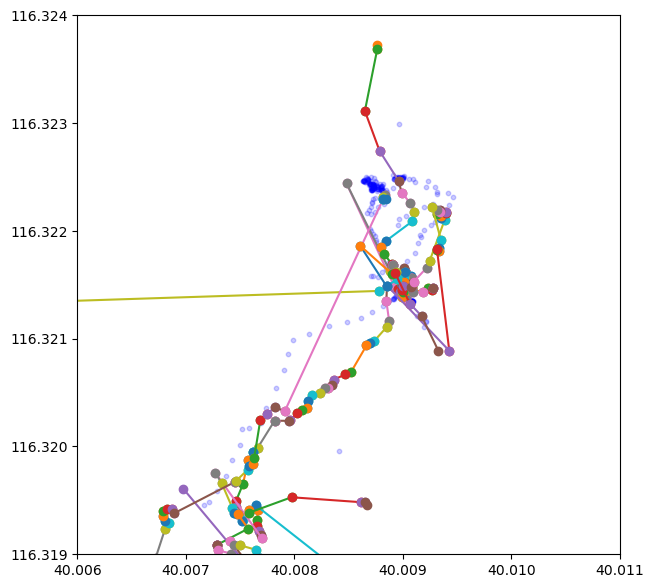

In [9]:
vis(graph_0, [40.006, 40.011], [116.319, 116.324])

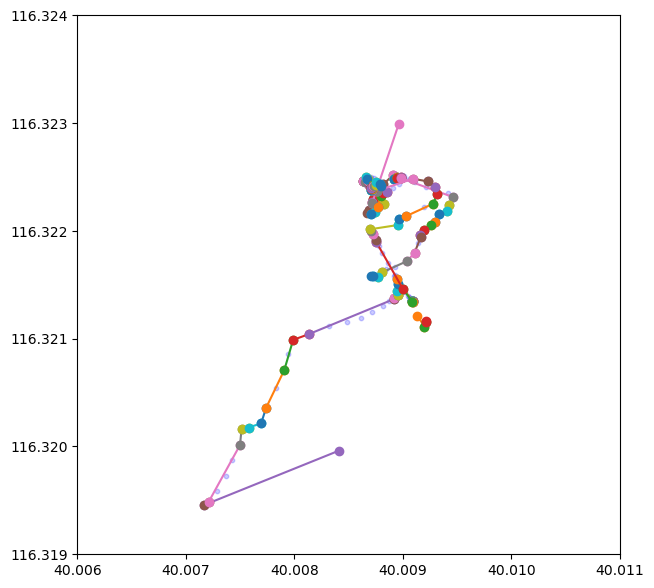

In [10]:
vis(graph_1, [40.006, 40.011], [116.319, 116.324])

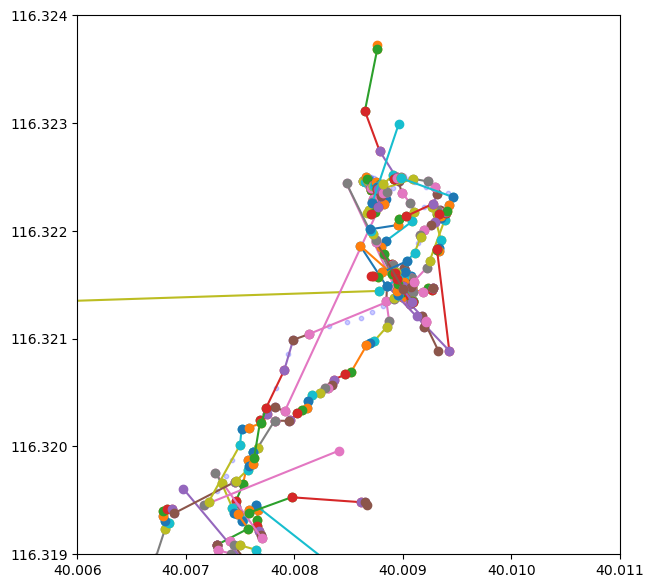

In [11]:
graph_0.combine_graph(graph_1)
vis(graph_0, [40.006, 40.011], [116.319, 116.324])

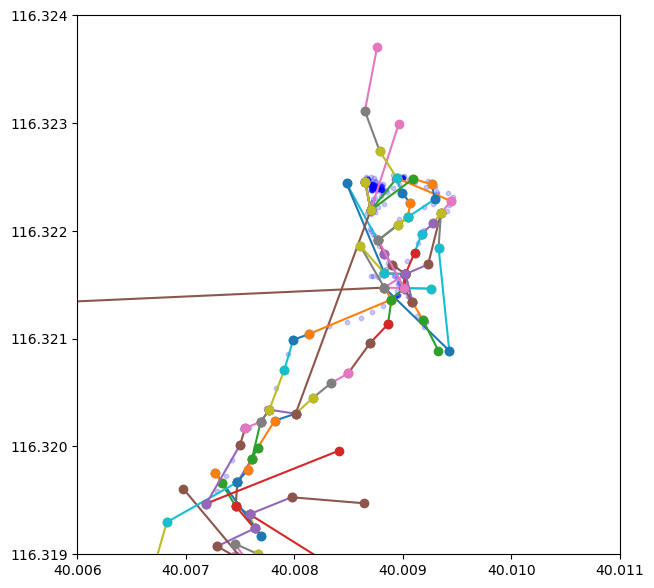

In [12]:
graph_0.merge_close_vertices()
garbage_collection()
graph_0.merge_vertices_to_edges()
vis(graph_0, [40.006, 40.011], [116.319, 116.324])

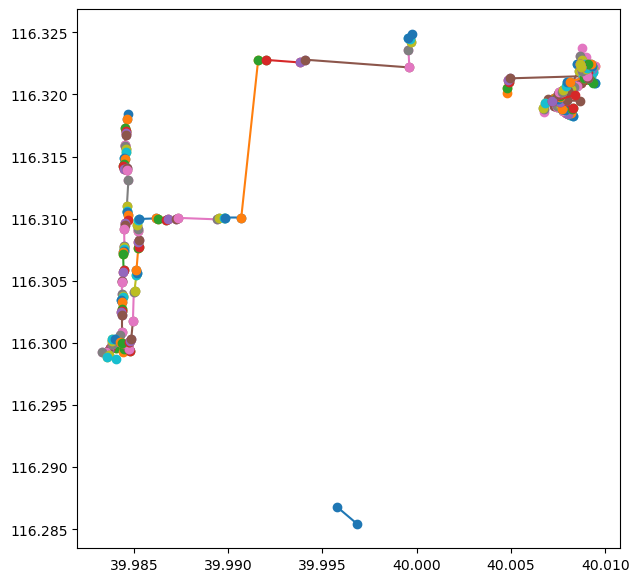

In [13]:
vis(graph_0)

(116.317, 116.322)

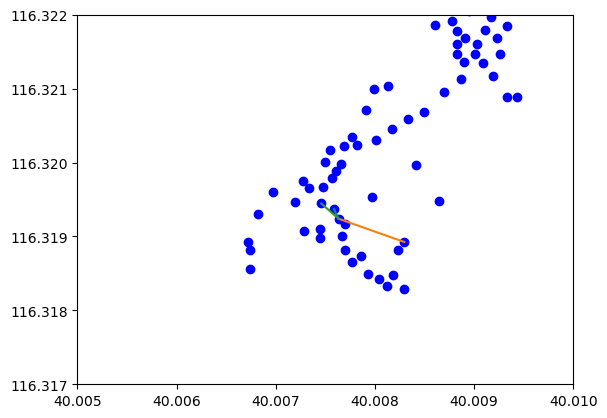

In [14]:
edge1 = [[40.007633,116.31923966666666], [40.007587,116.319371625]] 
edge2 = [[40.007633,116.31923966666666], [40.008296333333334,116.31892466666666]]
edge3 = [[40.007633,116.31923966666666], [40.007459142857144,116.31944564285715]]

edges = [edge1, edge2, edge3]
for vertex in graph_0.vertices:
    plt.plot(vertex.latitude, vertex.longitude, "bo")

for edge in edges:
    plt.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]])

plt.ticklabel_format(useOffset=False, style='plain')


plt.xlim([40.005, 40.010])
plt.ylim([116.317, 116.322])

In [15]:
t= [0,0,0,0,0]


In [16]:
graph.closest_vertex_to_point(40.008, 116.3203)

<Vertex: 19,19,0>

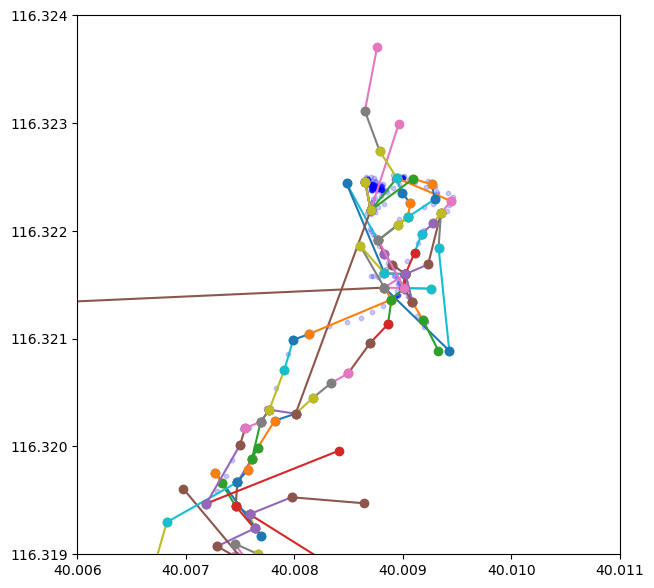

In [17]:
vis(graph_0, [40.006, 40.011], [116.319, 116.324])

In [18]:
# Additional idea: combine edges with similar angles
# For report we attempt to model the topology of a city (vertices, edges and planes) of a city from geographical data

### The actual graph

In [19]:
graph = create_azimuth_graph(dft, method = 4, splitting_method = 2, distance_multiplier = 5, max_angle_change = 15)

def vis(graph, xlim = None, ylim = None):
    fig, ax = plt.subplots(figsize = (7,7))
    ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

    for edge in graph.edges:
        lat1 = min(edge.vertices).latitude
        long1 = min(edge.vertices).longitude

        lat2 = max(edge.vertices).latitude
        long2 = max(edge.vertices).longitude

        plt.plot([lat1, lat2], [long1, long2], marker = 'o')

    star_vertices = [vertex for vertex in graph.vertices if len(vertex.edges) == 1]
    for vertex in star_vertices:
        ax.plot(vertex.latitude, vertex.longitude, markersize=50)

    ax = plt.gca()
    
    if xlim != None:
        ax.set_xlim(xlim)
        
    if ylim != None:
         ax.set_ylim(ylim)
        
    
    #ax.set_xlim([40.0035, 40.0115])
    #ax.set_ylim([116.3175, 116.3245])

    #ax.set_xlim([40.006, 40.009])
    #ax.set_ylim([116.318, 116.321])
    
    #ax.set_xlim([40.000, 40.005])
    #ax.set_ylim([116.320, 116.325])
    
    #print(f"reduced from {len(dft)} to {len(graph.vertices)} points")

In [20]:
# graph.simplify()
len(graph.vertices)
graph.merge_close_vertices()
len(graph.vertices)
graph.merge_vertices_to_edges()
# graph.simplify()